In [40]:
from __future__ import annotations
import operator
from typing import TypedDict, List, Annotated, Literal
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_ollama import ChatOllama
from pathlib import Path

In [41]:
# --- Schema Definitions ---

class Task(BaseModel):
    id: int
    title: str
    goal: str = Field(..., description="One sentence goal.")
    bullets: str = Field(..., min_length=3, max_length=5, description="3-5 points.")
    target_words: str = Field(..., description="120-450 words.")
    section_type: Literal[
        "intro", "core", "examples", "checklist", "common_mistakes", "conclusion"
    ] = Field(..., description="Use 'common_mistakes' exactly once.")


class Plan(BaseModel):
    blog_title: str
    audience: str = Field(..., description="Who this blog is for")
    tone: str = Field(..., description="Writing tone (e.g., practical, crisp)")
    tasks: List[Task]

Plan.model_rebuild()

class State(TypedDict):
    topic: str
    plan: Plan
    # Annotated with operator.add allows workers to append to this list in parallel
    sections: Annotated[List[str], operator.add]
    final: str

llm = ChatOllama(model="qwen2.5:7b-instruct")

In [42]:
# --- Node Functions ---

def orchestrator(state: State) -> dict:
    # Use structured output to get the Plan object
    structured_llm = llm.with_structured_output(Plan)
    plan = structured_llm.invoke([
        SystemMessage(content=(
        "You are a senior technical writer and developer advocate. Your job is to produce a "
                    "highly actionable outline for a technical blog post.\n\n"
                    "Hard requirements:\n"
                    "- Create 5–7 sections (tasks) that fit a technical blog.\n"
                    "- Each section must include:\n"
                    "  1) goal (1 sentence: what the reader can do/understand after the section)\n"
                    "  2) 3–5 bullets that are concrete, specific, and non-overlapping\n"
                    "  3) target word count (120–450)\n"
                    "- Include EXACTLY ONE section with section_type='common_mistakes'.\n\n"
                    "Make it technical (not generic):\n"
                    "- Assume the reader is a developer; use correct terminology.\n"
                    "- Prefer design/engineering structure: problem → intuition → approach → implementation → "
                    "trade-offs → testing/observability → conclusion.\n"
                    "- Bullets must be actionable and testable (e.g., 'Show a minimal code snippet for X', "
                    "'Explain why Y fails under Z condition', 'Add a checklist for production readiness').\n"
                    "- Explicitly include at least ONE of the following somewhere in the plan (as bullets):\n"
                    "  * a minimal working example (MWE) or code sketch\n"
                    "  * edge cases / failure modes\n"
                    "  * performance/cost considerations\n"
                    "  * security/privacy considerations (if relevant)\n"
                    "  * debugging tips / observability (logs, metrics, traces)\n"
                    "- Avoid vague bullets like 'Explain X' or 'Discuss Y'. Every bullet should state what "
                    "to build/compare/measure/verify.\n\n"
                    "Ordering guidance:\n"
                    "- Start with a crisp intro and problem framing.\n"
                    "- Build core concepts before advanced details.\n"
                    "- Include one section for common mistakes and how to avoid them.\n"
                    "- End with a practical summary/checklist and next steps.\n\n"
                    "Output must strictly match the Plan schema.")),
        HumanMessage(content=f"Topic: {state['topic']}")
    ])
    return {"plan": plan}

def fanout(state: State):
    # This creates a 'Send' object for every task in the plan
    return [
        Send("worker", {"task": task, "topic": state["topic"], "plan": state["plan"]})
        for task in state["plan"].tasks
    ]

def worker(payload: dict) -> dict:
    # 1. Properly unpack the payload
    task: Task = payload["task"]
    plan: Plan = payload["plan"]
    topic = payload["topic"]

    # 2. System message is already great, just call it
    system_prompt = (
        "You are a senior technical writer and developer advocate. Write ONE section "
        "of a technical blog post in Markdown.\n\n"
        "Hard constraints:\n"
        "- Follow the Goal and cover ALL Bullets.\n"
        "- Stay close to Target words (±15%).\n"
        "- Output ONLY Markdown (start with ## Section Title).\n"
        "- Be precise and implementation-oriented (developers should be able to apply it).\n"
        "- Prefer concrete details over abstractions: APIs, data structures, protocols, and exact terms.\n"
        "- When relevant, include at least one of:\n"
        "  * a small code snippet (minimal, correct, and idiomatic)\n"
        "  * a tiny example input/output\n"
        "  * a checklist of steps\n"
        "  * a diagram described in text (e.g., 'Flow: A -> B -> C')\n"
        "- Explain trade-offs briefly (performance, cost, complexity, reliability).\n"
        "- Call out edge cases / failure modes and what to do about them.\n"
        "- If you mention a best practice, add the 'why' in one sentence.\n\n"
        "Markdown style:\n"
        "- Start with a '## <Section Title>' heading.\n"
        "- Use short paragraphs, bullet lists where helpful, and code fences for code.\n"
        "- Avoid fluff. Avoid marketing language.\n"
        "- If you include code, keep it focused on the bullet being addressed.\n"
    )

    # 3. Use the actual variables in the Human Message
    human_prompt = (
        f"Blog Title: {plan.blog_title}\n"
        f"Audience: {plan.audience}\n"
        f"Tone: {plan.tone}\n"
        f"Topic: {topic}\n\n"
        f"Section: {task.title}\n"
        f"Goal: {task.goal}\n"
        f"Bullets: {task.bullets}\n"
        f"Target words: {task.target_words}"
    )

    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=human_prompt)
    ])

    # 4. IMPORTANT: Return the ID so the reducer can sort the sections
    return {"sections": [(task.id, response.content.strip())]}

def reducer(state: State) -> dict:
    # 1. Sort sections by their ID (index 0 of the tuple)
    # state['sections'] will look like: [(3, "text"), (1, "text"), (2, "text")]
    ordered_list = sorted(state["sections"], key=lambda x: x[0])
    
    # 2. Extract just the text
    body = "\n\n".join([content for _id, content in ordered_list])
    
    title = state["plan"].blog_title
    final_md = f"# {title}\n\n{body}\n"

    filename = f"{title.lower().replace(' ', '_')}.md"
    Path(filename).write_text(final_md, encoding="utf-8")

    return {"final": final_md}

In [43]:
# --- Graph Construction ---

workflow = StateGraph(State)

workflow.add_node("orchestrator", orchestrator)
workflow.add_node("worker", worker)
workflow.add_node("reducer", reducer)

workflow.add_edge(START, "orchestrator")
# Conditional edge handles the fan-out logic
workflow.add_conditional_edges("orchestrator", fanout, ["worker"])
workflow.add_edge("worker", "reducer")
workflow.add_edge("reducer", END)

app = workflow.compile()

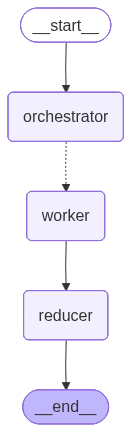

In [44]:
app

In [45]:
out = app.invoke({"topic":"Write a blog on Self Attention", "sections" : []})

In [46]:
print(out["plan"])

blog_title='Mastering Self-Attention in Transformers: A Developer’s Guide' audience='Developers familiar with neural networks, particularly those working on NLP tasks.' tone='Technical and actionable' tasks=[Task(id=1, title='Introduction to Self Attention Mechanism', goal='Understand the importance of self-attention in transformers for handling sequential data effectively.', bullets='urls,', target_words='[300]', section_type='intro'), Task(id=2, title='Problem: Handling Long Sequences in Neural Networks', goal='Recognize the limitations of traditional RNN and CNN models when dealing with long sequences.', bullets='List ', target_words='[450]', section_type='core'), Task(id=3, title='Intuition Behind Self-Attention', goal='Grasp the core intuition behind self-attention and how it enables parallelization in sequence modeling.', bullets='Extr', target_words='[400]', section_type='core'), Task(id=4, title='Approach: Implementing Self-Attention Mechanism', goal='Implement a simple self-at

In [47]:
print(out["final"])

# Mastering Self-Attention in Transformers: A Developer’s Guide

## Introduction to Self Attention Mechanism

Self-Attention, a key component in transformer models, allows each position in a sequence to attend to all positions in that same sequence. This mechanism is crucial for understanding the context and dependencies within sequences, making it indispensable for tasks like language modeling and text translation.

### Why Self Attention Matters

In traditional recurrent neural networks (RNNs), information flows through sequential processing, which can be slow and inefficient. Transformers, on the other hand, leverage self-attention to process all elements in parallel, significantly speeding up computation while maintaining or even improving performance. The self-attention mechanism computes a weighted sum of the query, key, and value vectors for each position, enabling the model to weigh different parts of the sequence more heavily based on their relevance.

### Basic Mechanics

The